In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [ ]:
df_raw = pd.read_csv("data/215379/WQBSLWQ.csv", low_memory=False)
df_raw["Temp"].dropna(inplace=True)
df_raw["F_Temp"] = df_raw["Temp"].apply(lambda x: x * 9/5 + 32)

df = df_raw[["F_Temp", 'DateTimeStamp']].copy()

df['DateTimeStamp'] = pd.to_datetime(df['DateTimeStamp'])
df['year'] = df['DateTimeStamp'].dt.year
df['month'] = df['DateTimeStamp'].dt.month
df['day'] = df['DateTimeStamp'].dt.day
df['time'] = df['DateTimeStamp'].dt.time
df.head()


In [ ]:
agg_df = df.groupby(by=["year", "month"])["F_Temp"].mean().round(2).reset_index()
plt.figure(figsize=(12, 6))
for year in agg_df['year'].unique():
    if year > 2015:
        monthly_data = agg_df[agg_df['year'] == year]
        plt.plot(monthly_data['month'], monthly_data['F_Temp'], marker='o', label=str(year))

plt.xlabel('Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import cm
from matplotlib import colors as mcolors

df_subset = df[df["month"] == 3]
df_subset = df_subset.reset_index()

unique_years = np.unique(df_subset["year"])
cmap = cm.get_cmap("tab10", len(unique_years))
color_mapping = {year: cmap(i) for i, year in enumerate(unique_years)}
colors = df_subset["year"].map(color_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(df_subset["day"], df_subset["F_Temp"], c=colors, marker=".")
plt.xlabel("Day")
plt.xticks(range(1, 32))
plt.grid(True)

norm = mcolors.Normalize(vmin=min(df_subset["year"]), vmax=max(df_subset["year"]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, label='Year')

plt.show()

In [ ]:
df[((df["month"] == 4) & (0 < df["day"]) & (df["day"] < 7)) & (df["year"] > 2020)]["F_Temp"].mean()

In [97]:
def ema(x: pd.Series, a): return sum(a*(1-a)**i * float(elem) for i, elem in enumerate(x))
df["ema"] = df["F_Temp"].rolling(window=10).apply(lambda x: ema(x, 0.2))


In [103]:

df["Special"] = df["F_Temp"].rolling(window=10).apply(lambda x: ema(x, 0.2))


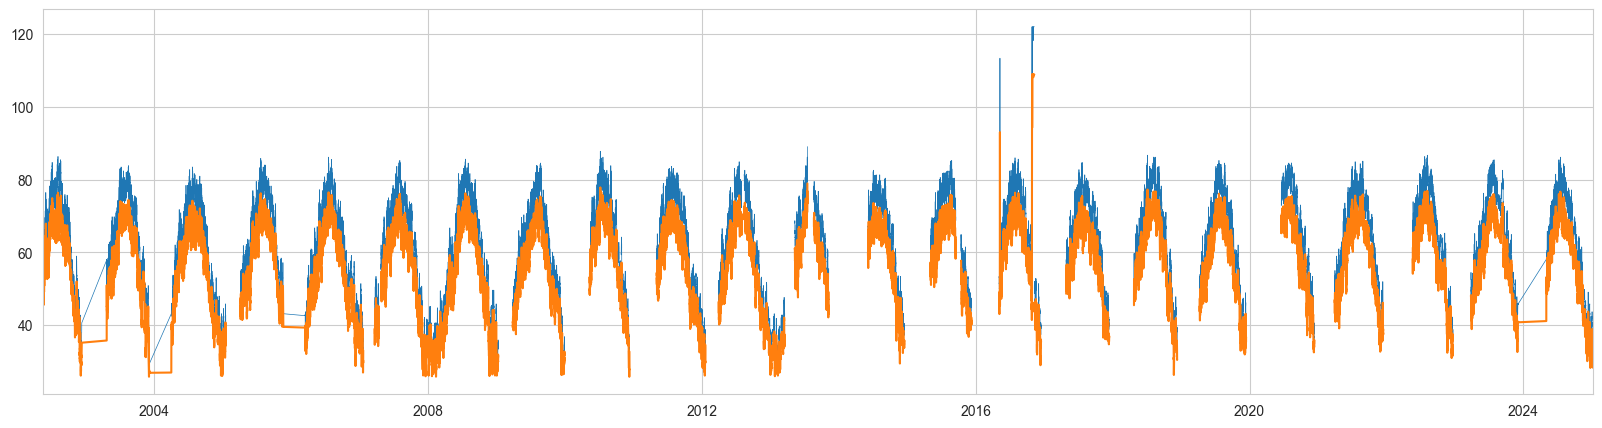

In [104]:


plt.figure(figsize=(20,5))
ax = plt.gca()
ax.set_xlim([df['DateTimeStamp'].min(), df['DateTimeStamp'].max()])

plt.plot(df['DateTimeStamp'], df["F_Temp"], lw=0.5)
plt.plot(df['DateTimeStamp'], df["Special"])
plt.show()

In [115]:
prophet_df = df.rename(columns={"DateTimeStamp": "ds", "F_Temp": "y"})

from prophet import Prophet

m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing


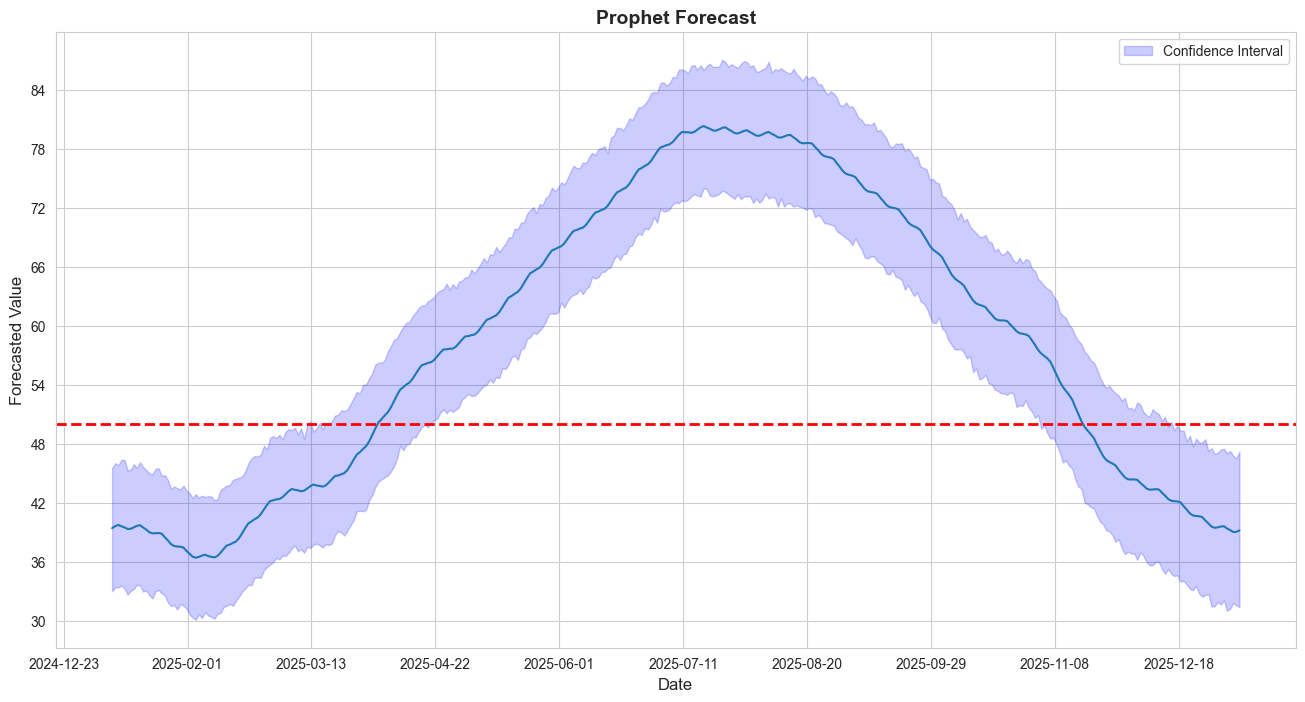

In [131]:
from matplotlib import ticker

forecast = forecast[forecast['ds'] > prophet_df["ds"].max()]

plt.figure(figsize=(16,8))
plt.plot(forecast['ds'], forecast["yhat"])
plt.fill_between(forecast['ds'], forecast["yhat_lower"], forecast["yhat_upper"], color='blue', alpha=0.2, label="Confidence Interval")
plt.axhline(y=50, color='red', linestyle='--', linewidth=2)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Forecasted Value", fontsize=12)
plt.title("Prophet Forecast", fontsize=14, fontweight="bold")
plt.legend()

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=12))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=12))

plt.show()



In [135]:

forecast[forecast['yhat'] > 45].sort_values(by=["ds"])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
667464,2025-03-23 15:15:00,56.740031,38.653606,51.310648,56.740031,56.753574,-11.735753,-11.735753,-11.735753,1.509095,...,-0.208233,-0.208233,-0.208233,-13.036615,-13.036615,-13.036615,0.0,0.0,0.0,45.004279
667465,2025-03-24 15:15:00,56.739460,39.131289,51.495062,56.739460,56.761130,-11.409863,-11.409863,-11.409863,1.509095,...,-0.195850,-0.195850,-0.195850,-12.723108,-12.723108,-12.723108,0.0,0.0,0.0,45.329597
667466,2025-03-25 15:15:00,56.738889,39.691331,52.068287,56.738889,56.764482,-10.908766,-10.908766,-10.908766,1.509095,...,-0.037523,-0.037523,-0.037523,-12.380338,-12.380338,-12.380338,0.0,0.0,0.0,45.830123
667467,2025-03-26 15:15:00,56.738318,40.215634,52.644177,56.736633,56.765909,-10.356375,-10.356375,-10.356375,1.509095,...,0.144134,0.144134,0.144134,-12.009604,-12.009604,-12.009604,0.0,0.0,0.0,46.381943
667468,2025-03-27 15:15:00,56.737747,41.124337,53.265622,56.734361,56.777829,-9.848664,-9.848664,-9.848664,1.509095,...,0.254947,0.254947,0.254947,-11.612706,-11.612706,-11.612706,0.0,0.0,0.0,46.889083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667710,2025-11-24 15:15:00,56.599526,39.174526,53.669315,53.254208,59.976948,-10.257442,-10.257442,-10.257442,1.509095,...,-0.195850,-0.195850,-0.195850,-11.570687,-11.570687,-11.570687,0.0,0.0,0.0,46.342084
667711,2025-11-25 15:15:00,56.598955,39.084312,53.897143,53.243794,59.997560,-10.466280,-10.466280,-10.466280,1.509095,...,-0.037523,-0.037523,-0.037523,-11.937852,-11.937852,-11.937852,0.0,0.0,0.0,46.132675
667712,2025-11-26 15:15:00,56.598384,38.705146,53.449977,53.242118,60.018171,-10.620922,-10.620922,-10.620922,1.509095,...,0.144134,0.144134,0.144134,-12.274151,-12.274151,-12.274151,0.0,0.0,0.0,45.977462
667713,2025-11-27 15:15:00,56.597813,38.028130,53.112665,53.240441,60.037012,-10.816214,-10.816214,-10.816214,1.509095,...,0.254947,0.254947,0.254947,-12.580257,-12.580257,-12.580257,0.0,0.0,0.0,45.781599
